In [37]:
import pandas as pd, seaborn as sns, numpy as np, datetime
from sklearn.metrics import accuracy_score
input_train = pd.read_csv('../data/fraud/05_model_input/x_train_transformed.csv')
output_train = pd.read_csv('../data/fraud/05_model_input/y_train_transformed.csv')

data = pd.concat([input_train, output_train['fraud_flag']], axis=1)
target = pd.get_dummies(data['fraud_flag'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0, shuffle=True, stratify=target)
print(f'input_train={len(input_train.index)},output_train={len(output_train.index)},data={len(data.index)},target={len(target.index)},x_train={len(x_train.index)},'+\
      f'x_test={len(x_test.index)},y_train={len(y_train.index)},y_test={len(y_test.index)}')
# print(f'y_test={y_test.head()}')
# print(f'x_test={x_test.head()}')
# print(f'output_train={output_train.head()}')
y_test['ID'] = x_test['ID']
y_test['fraud_flag'] = y_test[1.0]
# print(f'y_test={y_test.head()}')

input_train=62169,output_train=62169,data=62169,target=62169,x_train=49735,x_test=12434,y_train=49735,y_test=12434


In [54]:
print(len(target.index))
print(target.head())


62169
   0.0  1.0
0    1    0
1    1    0
2    1    0
3    1    0
4    1    0


In [2]:
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_seed
seed(1)
set_seed(2)

In [3]:
import seaborn as sns, keras
import matplotlib.pyplot as plt
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        metrics(str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("RMSE")

In [4]:
def score(y_true, y_pred_proba):
    import numpy as np
    from sklearn.metrics import average_precision_score
    ''' 
    Return the area under the Precision-Recall curve.  
    Args:
        - y_true (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the ground truth observations (second column).
        - y_pred_proba (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the predicted probabilities estimates for the minority class (second column).
    Returns:
        float
    '''   
    y_true_sorted = y_true.sort_values(by='ID').reset_index(drop=True)[['ID', 'fraud_flag']]
    y_pred_proba_sorted = y_pred_proba.sort_values(by='ID').reset_index(drop=True)[['ID', 'fraud_flag']]

    score = average_precision_score(np.ravel(y_true_sorted.iloc[:, 1]), np.ravel(y_pred_proba_sorted.iloc[:, 1]))
    return score

In [43]:
def build_model(activation_name='relu', batch_size = 10, epochs = 100):
    inputs = keras.Input(shape=x_train.shape[1])
    hidden_layer = keras.layers.Dense(20, activation=activation_name)(inputs)
    output_layer = keras.layers.Dense(2, activation="softmax")(hidden_layer)
    model = keras.Model(inputs=inputs, outputs=output_layer)
    y_columns = [0.0, 1.0]
    model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy())
    history = model.fit(x_train, y_train[y_columns], validation_data=(x_test, y_test[y_columns]), batch_size = batch_size, epochs = epochs, verbose=0)
    plot_history(history, 'val_loss')
    return model
def predict(estimator, x):
    y_predict = pd.DataFrame(x['ID'].copy(), columns=['ID'])
    prediction = estimator.predict(x)
    # print(f'{type(prediction)},prediction={prediction[:10]}')
    prediction = estimator.predict(x)
    y_predict['fraud_flag'] = [p[1] for p in prediction]
    # print(f'prediction={prediction[:10]}')
    y_predict = y_predict.reset_index(drop=True)
    return y_predict
def evaluate(model):
    y_predict = predict(model, x_test)
    current_score = score(y_test[['ID', 'fraud_flag']], y_predict)
    print(f'current_score={current_score}')
    return y_predict, current_score
def calibrate_model(activations, batch_size = 10, epochs = 100):
    best_score = 0
    best_model = None
    best_activation = None
    for activation in activations:
        start_time = datetime.datetime.now()
        model = build_model(activation, batch_size, epochs)
        y_predict = predict(model, x_test)
        current_score = score(y_test[['ID', 'fraud_flag']], y_predict)    
        end_time = datetime.datetime.now()
        duration = (end_time - start_time)
        print(f'{current_score} for {activation} in {duration}')
        if current_score > best_score:
            best_score = current_score
            best_activation = activation
            best_model = model
    print(f'The winner is {best_activation} with a score of {best_score} !')
    return best_model, best_activation, best_score

389/389 [==============================] - 0s 1ms/step
0.9750943054637595 for relu in 0:01:54.302241
389/389 [==============================] - 0s 968us/step
0.924768941347591 for softplus in 0:01:45.908681
389/389 [==============================] - 1s 1ms/step
0.06383546870601503 for selu in 0:01:37.501838
The winner is relu with a score of 0.9750943054637595 !


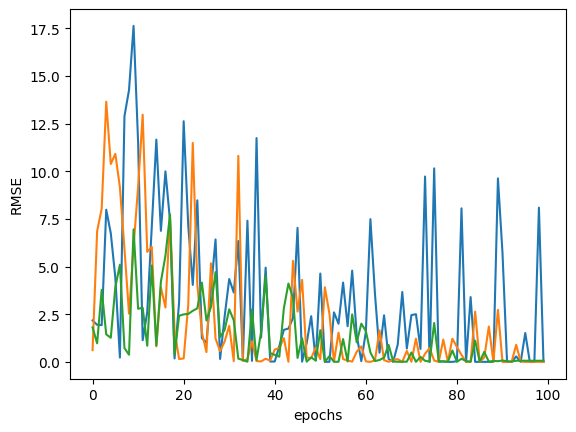

In [65]:
activations = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu']
activations = ['relu', 'softplus', 'selu']
best_model, best_activation, best_score = calibrate_model(activations, 100, 100)

389/389 [==============================] - 0s 1ms/step
0.9343684196612725 for relu in 0:01:41.216096
389/389 [==============================] - 0s 1ms/step
0.972334954360109 for softplus in 0:01:50.670269
389/389 [==============================] - 0s 877us/step
0.07265484020425297 for selu in 0:01:23.534037
The winner is softplus with a score of 0.972334954360109 !


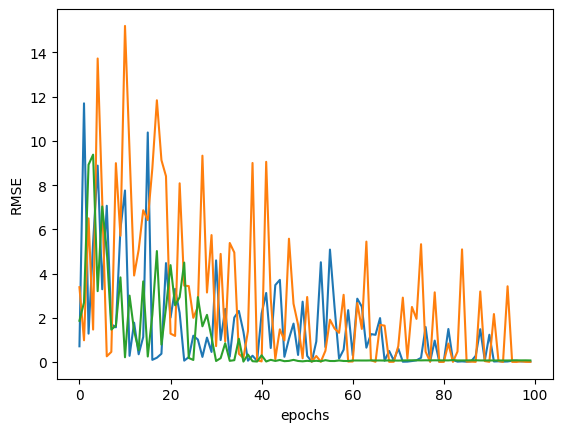

In [64]:
activations = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu']
activations = ['relu', 'softplus', 'selu']
best_model, best_activation, best_score = calibrate_model(activations, 100, 100)

In [ ]:
# example making new probability predictions for a classification problem
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
# generate 2d classification dataset
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1)
print(f'X={X[:10]}')
print(f'y={y[:10]}')
scalar = MinMaxScaler()
scalar.fit(X)
X = scalar.transform(X)
# define and fit the final model
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(X, y, epochs=500, verbose=0)
# new instances where we do not know the answer
Xnew, _ = make_blobs(n_samples=3, centers=2, n_features=2, random_state=1)
Xnew = scalar.transform(Xnew)
# make a prediction
ynew = model.predict(Xnew)
# show the inputs and predicted outputs
for i in range(len(Xnew)):
	print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))

In [ ]:
# model = build_model('elu', 10, 10)
y_predict = predict(model, x_test)
print(f'y_predict={y_predict.head()}')
# current_score = score(y_test['fraud_flag'].values.tolist(), y_predict['fraud_flag'].values.tolist())
# print('current_score={current_score}')

In [ ]:
# for activation_name in ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']:
build_model('relu')

In [ ]:
build_model('sigmoid')

In [ ]:
build_model('softmax')

In [ ]:
build_model('softplus')

In [ ]:
build_model('softsign')

In [ ]:
build_model('tanh')

In [ ]:
build_model('selu')

In [ ]:
build_model('elu')

In [ ]:
build_model('exponential')

In [ ]:
y_pred = model.predict(x_test)
prediction = pd.DataFrame(y_pred, columns=target.columns)
print(prediction.head())
print(y_test.head())
result = pd.concat([prediction, y_test], axis=1)
print(result.head(10))
# from sklearn.metrics import accuracy_score
# score = accuracy_score(y_test[target_field].values.tolist(), y_predict[target_field].values.tolist())
# print(score)